In [1]:
import sys

import matplotlib.pyplot as plt


sys.path.insert(0, "../")
%load_ext autoreload
%autoreload 2

In [2]:
import src
from src.datasets.coco_eft import COCO_EFT
from src.datasets.datasets_common import UNNORMALIZE
from src.utils.vis_utils import render_mesh_onto_image


# initialize the COCO dataset
ds = COCO_EFT()

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


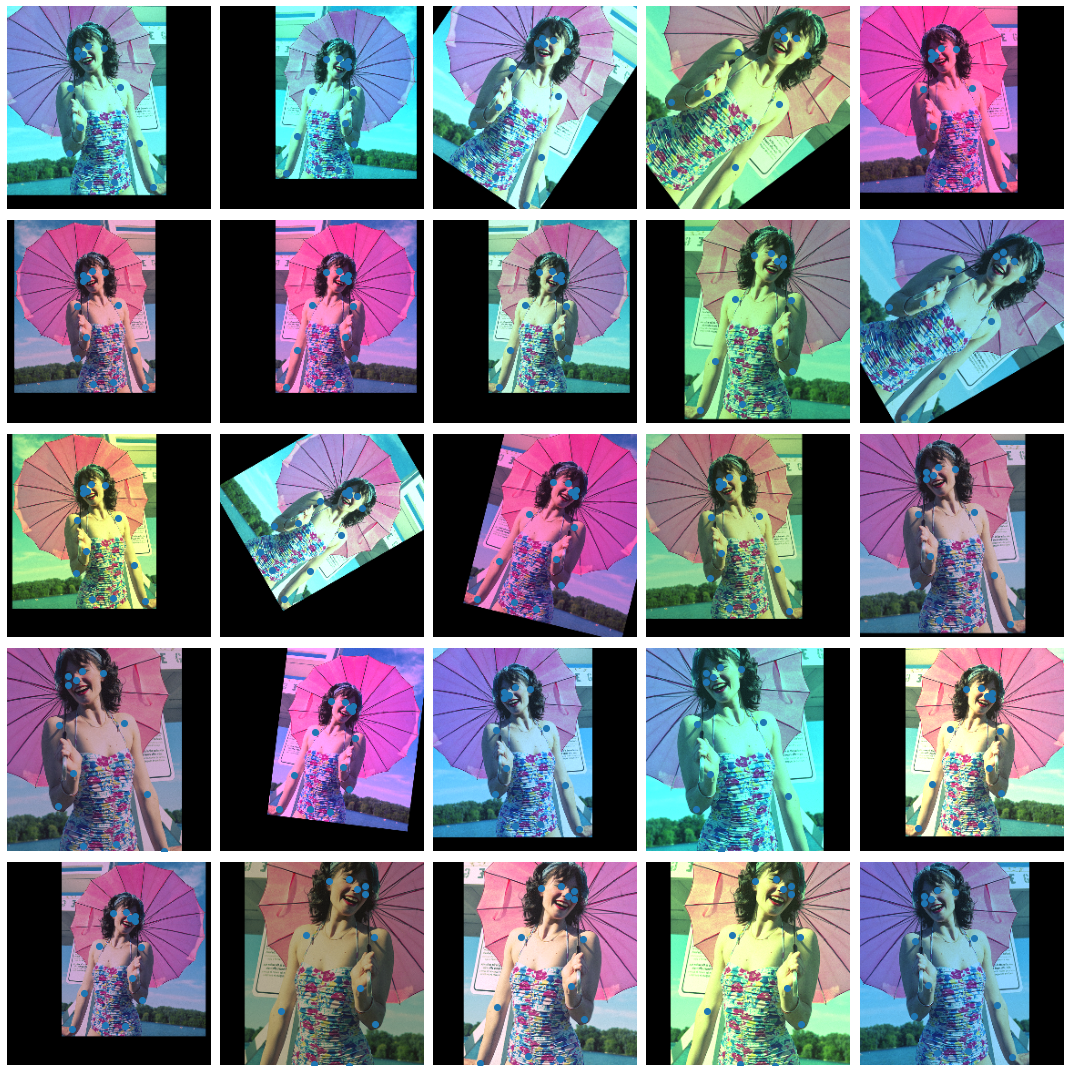

In [3]:
# show augmentations on one image
n = 5
fig, ax = plt.subplots(n, n, figsize=(15, 15))
for i in range(n):
    for j in range(n):
        x = ds[0]
        img = UNNORMALIZE(x["img"].unsqueeze(0))[0].permute(1, 2, 0)
        mask = x["gt2d"][:, 2] > 0
        ax[i, j].scatter(x["gt2d"][mask][:, 0], x["gt2d"][mask][:, 1])
        ax[i, j].imshow(img)
        ax[i, j].set_axis_off()

plt.subplots_adjust()
plt.tight_layout()

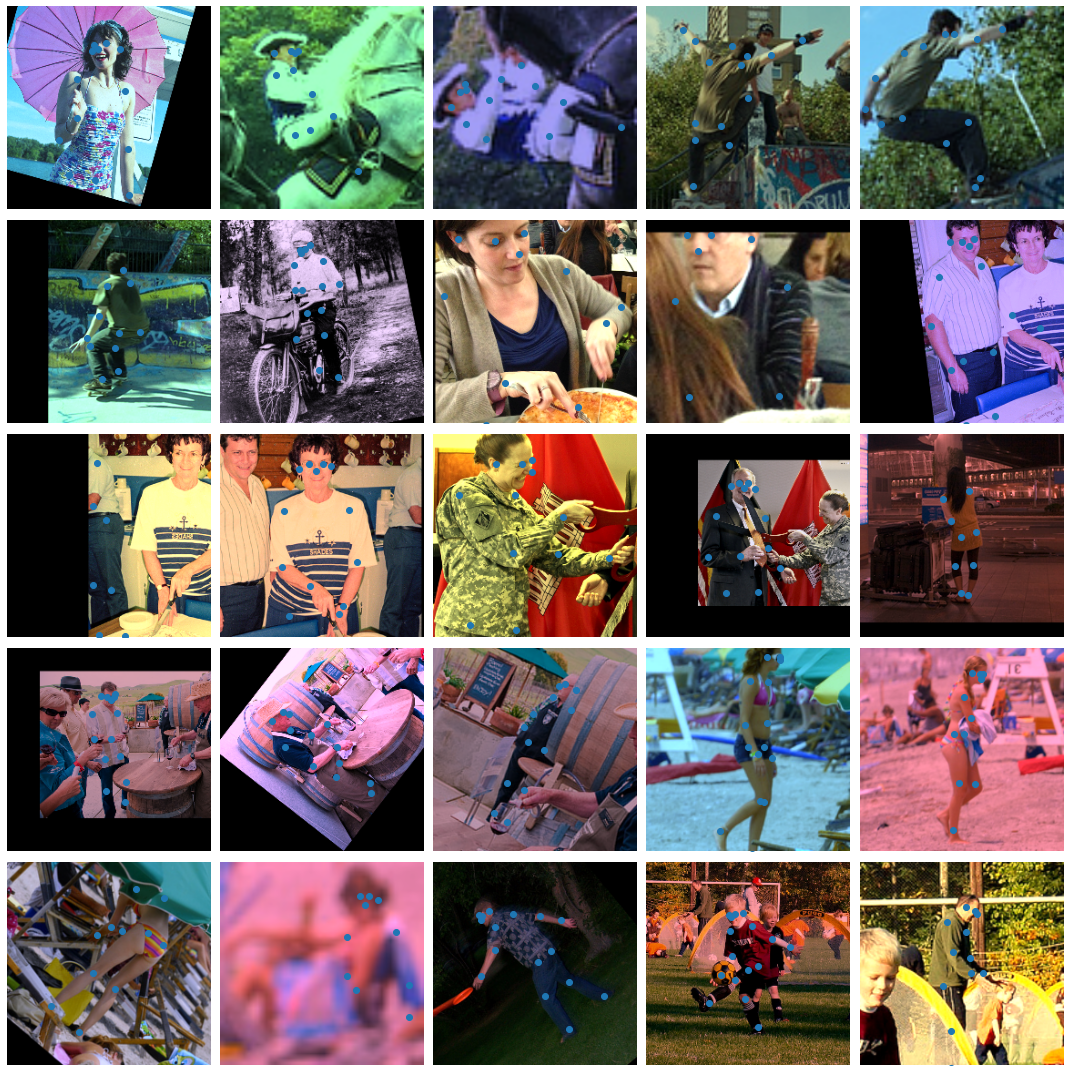

In [4]:
n = 5
fig, ax = plt.subplots(n, n, figsize=(15, 15))
for i in range(n):
    for j in range(n):
        x = ds[i * n + j]
        img = UNNORMALIZE(x["img"].unsqueeze(0))[0].permute(1, 2, 0)
        mask = x["gt2d"][:, 2] > 0
        ax[i, j].scatter(x["gt2d"][mask][:, 0], x["gt2d"][mask][:, 1])
        ax[i, j].imshow(img)
        ax[i, j].set_axis_off()

plt.subplots_adjust()
plt.tight_layout()

In [9]:
### render smpl bodies onto image
device = "cuda:1"
batch_size = 1

import torch
from src.functional import smpl
from src.utils import img_utils, vis_utils


smpl_model = smpl.get_smpl_model(batch_size=batch_size, device=device)
faces = smpl_model.faces.astype(int)

ds = COCO_EFT(is_train=False)

/tmp/ipykernel_21098/892011334.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale, trans = torch.tensor(x["parm_cam"][0]), torch.tensor(x["parm_cam"][1:])


Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size 

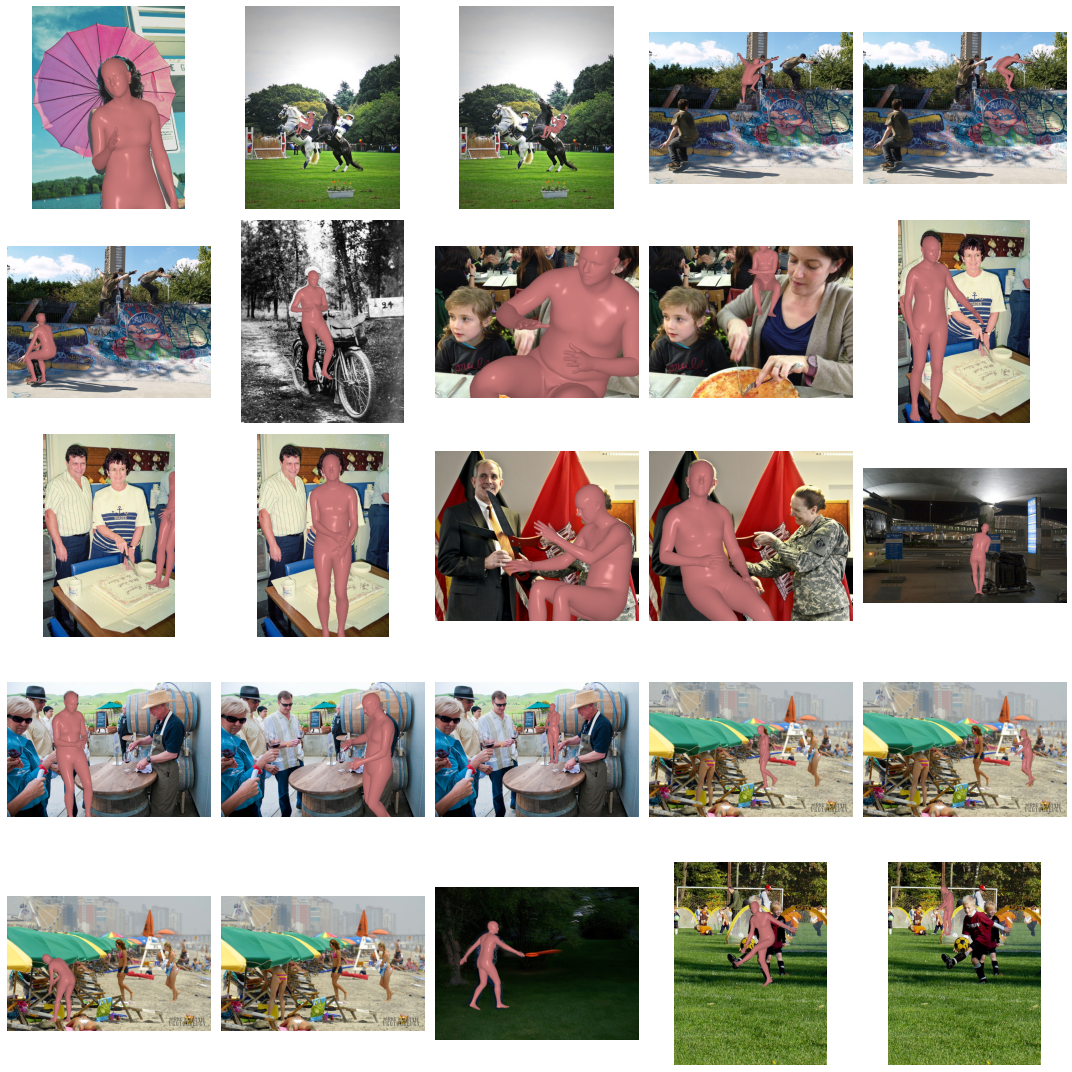

In [20]:
n = 5
fig, ax = plt.subplots(n, n, figsize=(15, 15))
for i in range(n):
    for j in range(n):
        x = ds[i * n + j]
        img_original = ds.get_img(x["imgName"])

        ### render smpl mesh
        shape = x["smpl_shape"].unsqueeze(0).clone().to(device)
        pose = x["smpl_pose"][3:].unsqueeze(0).clone().to(device)
        global_orient = x["smpl_pose"][:3].unsqueeze(0).clone().to(device)

        output = smpl_model(
            betas=shape, body_pose=pose, global_orient=global_orient, expression=None, return_verts=True
        )
        vertices = output.vertices

        ### align mesh vertices with body pixels
        scale, trans = torch.tensor(x["parm_cam"][0]), torch.tensor(x["parm_cam"][1:])
        boxScale_o2n, bboxTopLeft = x["bboxInfoScale"], x["bboxInfoTopLeft"]
        
        img_verts = img_utils.convert_smpl_vertices_to_image_coord(
            vertices.cpu(),
            scale.unsqueeze(0),
            trans.unsqueeze(0),
            boxScale_o2n.unsqueeze(0),
            bboxTopLeft.unsqueeze(0),
            torch.tensor(img_original.shape[:2]).unsqueeze(0),
            scaled_size=x["crop_shape"].unsqueeze(0),
        )[0]
        blend_img = render_mesh_onto_image(img_original, img_verts.cpu().numpy(), faces)

        ax[i, j].imshow(blend_img)
        ax[i, j].set_axis_off()


plt.subplots_adjust()
plt.tight_layout()

In [45]:
### render smpl bodies onto augmented image  TODO
# To align bbox-cropped/scaled images with smpl renders, one needs to implement augment.j3d_augment function
# To align mesh in augmented image, uncrop body to original, then apply augmentation to 3d